<a href="https://colab.research.google.com/github/ricardoruedas/ML/blob/main/%5B05%5D%20-%20Arboles%20de%20decision/TFM_Ejercicio_Barrios_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-proyecto ML (TFM): ¿Dónde vivir bien sin ser el barrio más caro?

**Objetivo educativo**: Construir un ejemplo end-to-end de *Machine Learning* para responder a una pregunta práctica: **identificar zonas con buena calidad de vida relativa sin pagar el máximo precio**.

Usaremos el dataset **California Housing** (público) que contiene variables como ingreso medio del bloque, edad de las viviendas, número de habitaciones, población, latitud/longitud y proximidad al océano.


## Índice
1. Planteamiento y datos
2. Carga del dataset
3. EDA: exploración rápida
4. Ingeniería de variables (features nuevas)
5. Definición de una **etiqueta** de clasificación: *buena relación calidad/precio*
6. Partición Train/Test
7. Pipeline de preprocesado y modelos
8. Evaluación (Accuracy, ROC-AUC, matriz de confusión)
9. Importancia de variables (Gini + Permutación)
10. Conclusiones y siguientes pasos


## 1) Planteamiento y datos
**Pregunta**: *¿Dónde vivir bien sin ser el barrio más caro?*

En ausencia de un dataset perfecto de "barrios" con todas las dimensiones (aire, crimen, etc.), utilizaremos el dataset **California Housing** (bloques censales) y crearemos **variables proxy** para aproximar aspectos de calidad de vida y coste:

- **Coste** (proxy): `median_house_value` (precio mediano vivienda) y derivados como `coste_por_habitación`.
- **Calidad** (proxy): `median_income` (ingreso medio del área), `habitaciones_por_hogar`, `densidad_población`, `proximidad_al_océano`.

**Idea**: Crear un **índice de relación calidad/precio (RCP)** a partir de proxies y, con él, etiquetar como `1` las zonas con **RCP alto** y **precio no extremo**. Luego entrenamos un **clasificador** para aprender qué variables explican esa etiqueta y así medir **importancias**.

## 2) Carga del dataset
Descargamos el CSV público (no se requiere cuenta):

- Fuente CSV: `https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv`

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## 3) EDA: exploración rápida
- Tamaño y nulos
- Estadísticos descriptivos
- Distribución de variables clave
- Relación precio vs. otras variables (visión rápida)

In [2]:
import numpy as np

print("Filas, columnas:", df.shape)
df.isna().mean().sort_values(ascending=False).head(10)


Filas, columnas: (20640, 10)


,0
total_bedrooms,0.010029
longitude,0.000000
latitude,0.000000
housing_median_age,0.000000
total_rooms,0.000000
population,0.000000
households,0.000000
median_income,0.000000
median_house_value,0.000000
ocean_proximity,0.000000


In [3]:
df.describe(include="all")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9136
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,NaN
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,NaN
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,NaN
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,NaN


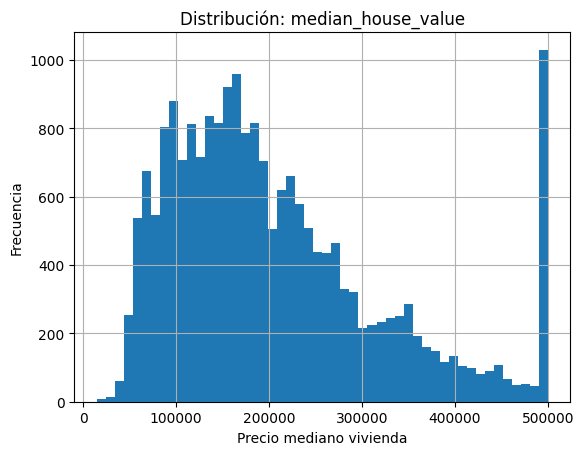

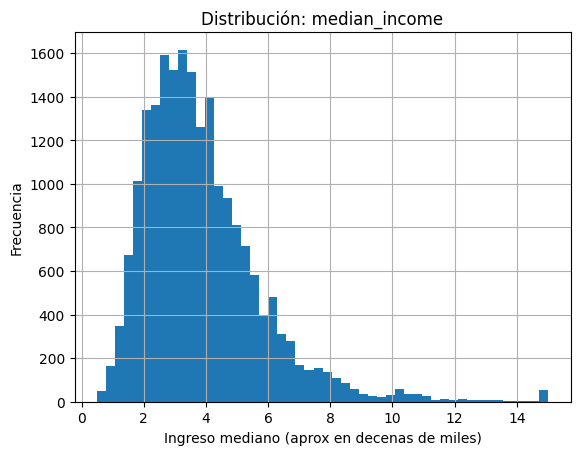

In [4]:
import matplotlib.pyplot as plt

# Histograma de variable objetivo económica (precio)
plt.figure()
df["median_house_value"].hist(bins=50)
plt.title("Distribución: median_house_value")
plt.xlabel("Precio mediano vivienda")
plt.ylabel("Frecuencia")
plt.show()

# Ingreso medio
plt.figure()
df["median_income"].hist(bins=50)
plt.title("Distribución: median_income")
plt.xlabel("Ingreso mediano (aprox en decenas de miles)")
plt.ylabel("Frecuencia")
plt.show()


## 4) Ingeniería de variables
Creamos variables alineadas con el objetivo:

- `rooms_per_household` = `total_rooms` / `households` (tamaño medio vivienda)
- `bedrooms_per_room` = `total_bedrooms` / `total_rooms` (intensidad de dormitorios)
- `population_per_household` = `population` / `households` (tamaño medio hogar / densidad en vivienda)
- `cost_per_room` = `median_house_value` / `total_rooms`
- `value_to_income_ratio` = `median_house_value` / (`median_income` * 10,000) *(ratio coste-ingresos)*
- Variables dummificadas de `ocean_proximity` (proximidad al océano)


In [5]:
df_fe = df.copy()

# Evitar divisiones por 0 usando replace(0, np.nan)
den_safe = lambda s: s.replace(0, np.nan)

df_fe["rooms_per_household"] = df_fe["total_rooms"] / den_safe(df_fe["households"]) #habitaciones por hogar (tamaño medio de las viviendas en la zona). Idea: más habitaciones por hogar suele indicar viviendas más espaciosas.
df_fe["bedrooms_per_room"] = df_fe["total_bedrooms"] / den_safe(df_fe["total_rooms"]) #proporción de dormitorios sobre habitaciones. Idea: si es muy alta, quizá son viviendas “más dormitorizadas” (menos salas/espacios comunes), lo que puede decir algo sobre el tipo de vivienda o densidad.
df_fe["population_per_household"] = df_fe["population"] / den_safe(df_fe["households"])# personas por hogar (tamaño medio de hogar). Idea: valores altos pueden indicar mayor densidad por vivienda (familias grandes, pisos compartidos, etc.).
df_fe["cost_per_room"] = df_fe["median_house_value"] / den_safe(df_fe["total_rooms"]) # coste aproximado por habitación en el bloque. Idea: normaliza el precio por “capacidad” habitacional; útil para comparar áreas con tamaños de vivienda distintos.
df_fe["value_to_income_ratio"] = df_fe["median_house_value"] / (df_fe["median_income"] * 10000.0) #ratio valor/ingresos (una proxy de asequibilidad). Por qué * 10000: en este dataset, median_income está escalado (≈ “decenas de miles”). Multiplicar por 10 000 lo lleva a “dinero real aproximado” para que la división tenga sentido.Idea: cuanto más alto el ratio, menos asequible (precio alto respecto a ingresos).

# Dummies de proximidad al océano
df_fe = pd.get_dummies(df_fe, columns=["ocean_proximity"], drop_first=True)

df_fe.sample(5, random_state=42)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,cost_per_room,value_to_income_ratio,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,4.192201,NaN,3.877437,31.694352,2.837259,True,False,False,False
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,5.039384,NaN,2.679795,15.562351,1.809347,True,False,False,False
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,3.977155,NaN,1.360332,130.548564,14.367432,False,False,True,False
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,6.163636,NaN,3.444444,71.648640,3.809955,False,False,False,False
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,5.492991,NaN,2.483645,118.247554,7.463087,False,False,False,True


## 5) Definición de la etiqueta: *buena relación calidad/precio*
Construimos dos índices estandarizados:

- **Índice de Calidad (IC)** (más alto = mejor): basado en `median_income` (+), `rooms_per_household` (+), `population_per_household` (-, preferimos menor), y `ocean_proximity_Island/NEAR BAY/NEAR OCEAN` (+ si existen).
- **Índice de Coste (ICo)** (más alto = más caro): `median_house_value` (+) y `cost_per_room` (+).

Definimos una **puntuación RCP** = **IC - ICo** (normalizados). Etiquetamos como `1` los bloques con RCP **en el cuartil superior (>= Q3)** y con `median_house_value` **por debajo del percentil 70** (evitamos los más caros).

In [6]:
from sklearn.preprocessing import StandardScaler

fe_cols_quality_plus = ["median_income", "rooms_per_household"]
fe_cols_quality_minus = ["population_per_household"]

# Dummies de proximidad que existan tras get_dummies (pueden variar según dataset)
dummy_cols = [c for c in df_fe.columns if c.startswith("ocean_proximity_")]
fe_cols_quality_plus += dummy_cols  # se suman como 'mejora'

# Índice de coste
fe_cols_cost = ["median_house_value", "cost_per_room"]

scaler_q = StandardScaler()
scaler_c = StandardScaler()

# Construcción de IC
IC = np.zeros(len(df_fe))
if fe_cols_quality_plus:
    IC += scaler_q.fit_transform(df_fe[fe_cols_quality_plus].fillna(0)).sum(axis=1).ravel()
if fe_cols_quality_minus:
    IC -= scaler_q.fit_transform(df_fe[fe_cols_quality_minus].fillna(0)).sum(axis=1).ravel()

# Construcción de ICo
ICo = scaler_c.fit_transform(df_fe[fe_cols_cost].fillna(0)).sum(axis=1).ravel()

# Puntuación final
RCP = IC - ICo
df_fe["RCP_score"] = RCP

# Umbrales
q3_rcp = np.nanpercentile(RCP, 75)
p70_price = np.nanpercentile(df_fe["median_house_value"], 70)

df_fe["good_value"] = ((df_fe["RCP_score"] >= q3_rcp) & (df_fe["median_house_value"] <= p70_price)).astype(int)

df_fe["good_value"].value_counts(normalize=True)


,proportion
good_value,
0,0.807364
1,0.192636


###Borro las variables usadas para crear las nuevas?

Empieza dejando ambas (originales + nuevas) y decide con validación. Luego, si ves redundancias claras o problemas de colinealidad/explicabilidad, recorta.

- Modelos distintos toleran redundancia de forma diferente:
- Las originales se quitan cuando hay una colinealidad fuerte.

In [7]:
df_fe.sample(5, random_state=42)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,cost_per_room,value_to_income_ratio,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,RCP_score,good_value
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,4.192201,NaN,3.877437,31.694352,2.837259,True,False,False,False,0.510245,0
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,5.039384,NaN,2.679795,15.562351,1.809347,True,False,False,False,1.451211,1
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,3.977155,NaN,1.360332,130.548564,14.367432,False,False,True,False,-1.389689,0
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,6.163636,NaN,3.444444,71.648640,3.809955,False,False,False,False,-0.193251,0
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,5.492991,NaN,2.483645,118.247554,7.463087,False,False,False,True,0.983791,0


## 6) Partición Train/Test
Usamos un 20% para test y estratificación por la etiqueta `good_value`.

In [8]:
from sklearn.model_selection import train_test_split

target = "good_value"

# Selección de features (todas numéricas ya dummificadas; excluimos la variable objetivo y la RCP)
drop_cols = ["good_value", "RCP_score"]
X = df_fe.drop(columns=drop_cols)
y = df_fe[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean()


((16512, 18), (4128, 18), np.float64(0.19264777131782945))

## 7) Pipeline de preprocesado y modelos
Como todas las variables están numéricas (tras dummies), aplicamos **imputación simple** y **escalado**. Entrenaremos dos modelos:

- **Regresión Logística** (lineal, interpretable via coeficientes)
- **RandomForestClassifier** (no lineal, buena referencia y con *feature importance* por Gini)


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_reg = Pipeline(steps=[
    ("prep", num_pipeline),
    ("model", LogisticRegression(max_iter=1000, n_jobs=None))  # n_jobs param removed for compatibility
])

rf = Pipeline(steps=[
    ("prep", num_pipeline),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

log_reg, rf


(Pipeline(steps=[('prep',
                  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler', StandardScaler())])),
                 ('model', LogisticRegression(max_iter=1000))]),
 Pipeline(steps=[('prep',
                  Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler', StandardScaler())])),
                 ('model',
                  RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                         random_state=42))]))

## 8) Evaluación
Mediremos **Accuracy** y **ROC-AUC** y mostraremos la **matriz de confusión**.

In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# Entrenamiento
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Predicciones
proba_lr = log_reg.predict_proba(X_test)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf = (proba_rf >= 0.5).astype(int)

# Métricas
def eval_model(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"Modelo: {name}\nAccuracy: {acc:.3f} | ROC-AUC: {auc:.3f}\n")
    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de confusión:\n", cm, "\n")
    return acc, auc, cm

acc_lr, auc_lr, cm_lr = eval_model(y_test, pred_lr, proba_lr, "LogisticRegression")
acc_rf, auc_rf, cm_rf = eval_model(y_test, pred_rf, proba_rf, "RandomForest")


Modelo: LogisticRegression
Accuracy: 0.934 | ROC-AUC: 0.975

Matriz de confusión:
 [[3218  115]
 [ 159  636]] 

Modelo: RandomForest
Accuracy: 0.986 | ROC-AUC: 0.999

Matriz de confusión:
 [[3315   18]
 [  39  756]] 



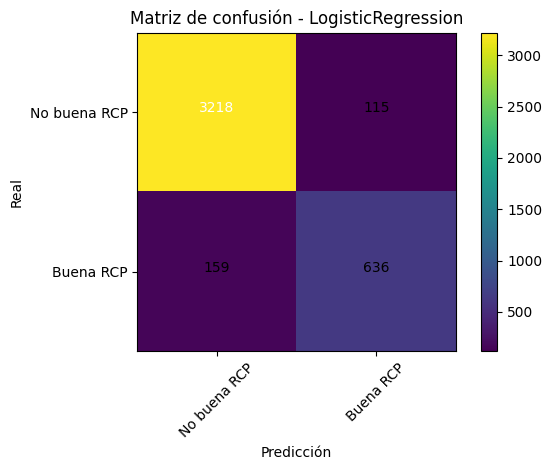

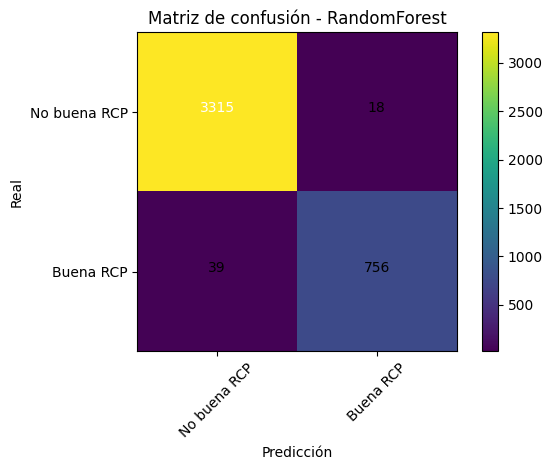

In [11]:
# Visualizar matrices de confusión
import matplotlib.pyplot as plt
import numpy as np

for name, cm in [("LogisticRegression", cm_lr), ("RandomForest", cm_rf)]:
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Matriz de confusión - {name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["No buena RCP", "Buena RCP"], rotation=45)
    plt.yticks(tick_marks, ["No buena RCP", "Buena RCP"])
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()


## 9) Importancia de variables
Vemos la importancia por **Gini** del `RandomForest` y calculamos **Permutation Importance** sobre el conjunto de test para una visión robusta de impacto en la métrica.

> Nota: la importancia por Gini mide reducción de impureza; *Permutation Importance* mide pérdida de rendimiento al permutar una variable.

In [12]:
import pandas as pd
from sklearn.inspection import permutation_importance

# (A) Importancia por Gini (del bosque) — hay que extraer del paso 'model'
rf_model = rf.named_steps['model']

# Para mapear a nombres de columnas tras 'prep', el StandardScaler no cambia nombres,
# porque aquí no hay OneHotEncoder, así que son los mismos de X.
gini_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
gini_importances.head(15)


,0
value_to_income_ratio,0.192459
rooms_per_household,0.147753
median_house_value,0.111194
median_income,0.083040
bedrooms_per_room,0.068512
ocean_proximity_INLAND,0.066999
longitude,0.060538
latitude,0.056243
ocean_proximity_NEAR OCEAN,0.047433
ocean_proximity_NEAR BAY,0.038998


In [13]:
# (B) Permutation Importance en test
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
perm_importances.head(15)


,0
ocean_proximity_INLAND,0.091449
median_house_value,0.086604
value_to_income_ratio,0.084351
rooms_per_household,0.080208
ocean_proximity_NEAR OCEAN,0.041109
median_income,0.028173
ocean_proximity_NEAR BAY,0.027253
bedrooms_per_room,0.006710
cost_per_room,0.002350
longitude,0.002277


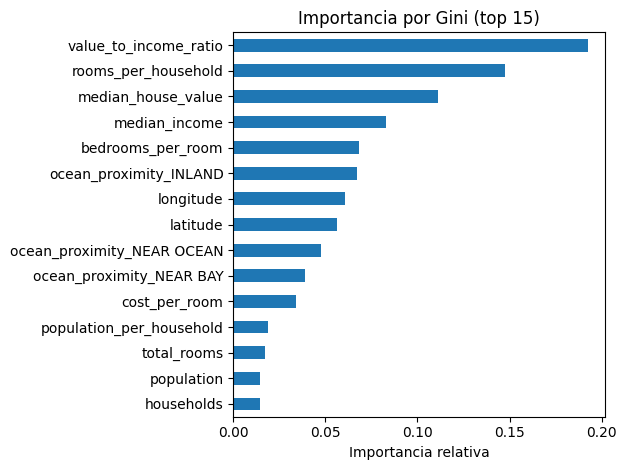

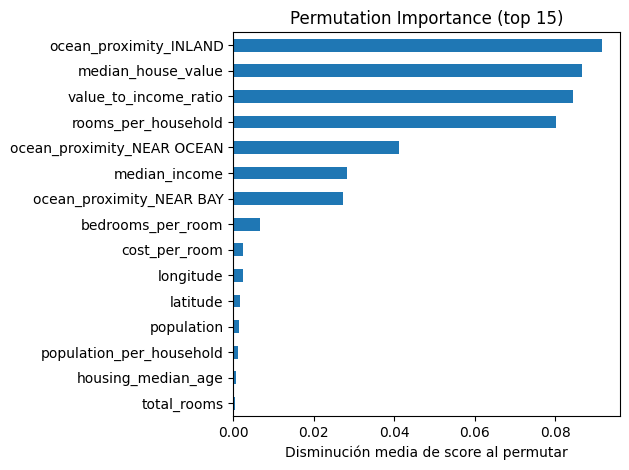

In [14]:
# Gráficos (top 15)
plt.figure()
gini_importances.head(15).iloc[::-1].plot(kind='barh')
plt.title("Importancia por Gini (top 15)")
plt.xlabel("Importancia relativa")
plt.tight_layout()
plt.show()

plt.figure()
perm_importances.head(15).iloc[::-1].plot(kind='barh')
plt.title("Permutation Importance (top 15)")
plt.xlabel("Disminución media de score al permutar")
plt.tight_layout()
plt.show()


## 10) Conclusiones y siguientes pasos
**Qué hemos hecho:**
1. Definimos una **pregunta** práctica y una forma de **operacionalizarla** con proxies.
2. Descargamos y exploramos el dataset California Housing.
3. Creamos **features** nuevas (densidad, tamaño por hogar, coste por habitación, ratio valor/ingresos, proximidad al océano).
4. Construimos un **índice de calidad** y otro de **coste**, y con ambos definimos una **etiqueta** de *buena relación calidad/precio*.
5. Entrenamos **dos modelos** (Logistic Regression y Random Forest).
6. Evaluamos con **Accuracy y ROC-AUC**, y analizamos **importancia de variables** (Gini + Permutación).

**Siguientes pasos:**
- Sustituir proxies por **indicadores reales** (calidad del aire, criminalidad, servicios, transporte, colegios).
- **Validación más rigurosa** (estratificación espacial, *k-fold*, calibración de probas, *threshold tuning*).
- **Explicabilidad**: SHAP/Partial Dependence Plots.
- **Modelos geoespaciales**: incluir vecindario (kNN espacial) o *geographically weighted models*.
- **Optimización**: búsqueda de hiperparámetros (Grid/Random/Bayesiana).

## 11) Diagnóstico de Colinealidad de Variables

Correlaciones pareadas (no detecta colinealidad multivariable, pero da señales):

Alerta: |r| ≥ 0.80–0.90.


In [15]:
# --- 11.1 Correlaciones pareadas (|r| altas) ---
import numpy as np
import pandas as pd

# Selecciona variables numéricas (tras dummies). Ajusta si tu X tiene otro nombre, solo las numericas pueden tener relacion.
X_num = X.select_dtypes(include=[np.number]).copy()

# Calcula la matriz de correlación de Pearson entre todas las columnas y toma el valor absoluto
corr_abs = X_num.corr().abs()
pairs = (
    corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
            .stack()
            .sort_values(ascending=False)
)

print("Top 20 pares más correlacionados (correlación absoluta):\n")
display(pairs.head(20))

# Umbral de alerta de colinealidad pareada
THRESH_CORR = 0.85
high_corr_pairs = pairs[pairs >= THRESH_CORR]
print(f"\nNúmero de pares con |r| >= {THRESH_CORR}: {high_corr_pairs.shape[0]}")
display(high_corr_pairs.head(20))


Top 20 pares más correlacionados (correlación absoluta):



total_bedrooms       households               0.979728
total_rooms          total_bedrooms           0.930380
longitude            latitude                 0.924664
total_rooms          households               0.918484
population           households               0.907222
total_bedrooms       population               0.877747
total_rooms          population               0.857126
median_income        median_house_value       0.688075
                     bedrooms_per_room        0.615661
median_house_value   value_to_income_ratio    0.442203
bedrooms_per_room    value_to_income_ratio    0.420040
rooms_per_household  bedrooms_per_room        0.416952
housing_median_age   total_rooms              0.361262
median_income        rooms_per_household      0.326895
housing_median_age   total_bedrooms           0.320451
                     households               0.302916
                     population               0.296244
median_house_value   bedrooms_per_room        0.255880
housing_median_age   value_to_income_ratio    0.202430
total_rooms          median_income            0.198050
dtype: float64


Número de pares con |r| >= 0.85: 7


,,0
total_bedrooms,households,0.979728
total_rooms,total_bedrooms,0.930380
longitude,latitude,0.924664
total_rooms,households,0.918484
population,households,0.907222
total_bedrooms,population,0.877747
total_rooms,population,0.857126
